In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# Read csv data
train = pd.read_csv("dataset_layer7/train.csv")
valid = pd.read_csv("dataset_layer7/valid.csv")

In [3]:
print("Shape of the train dataset : ", train.shape)
print("Shape of the valid dataset : ", valid.shape)

Shape of the train dataset :  (28520, 772)
Shape of the valid dataset :  (750, 772)


In [4]:
# Find out the number of rows with missing values for each column.
def check_missing_values(label):
    print("Missing values in {label}: {val}".format(label=label, val=train[label].isna().sum()))

# Check missing values in labels
for label in ['label_1', 'label_2', 'label_3', 'label_4']:
    check_missing_values(label)
    
# Check for missing values in feature columns
for i in range(1, 773-4):
    if train[label].isna().sum() > 0:
        check_missing_values('feature_' + str(i))
else:
    print("No missing values in feature columns.") 

Missing values in label_1: 0
Missing values in label_2: 480
Missing values in label_3: 0
Missing values in label_4: 0
No missing values in feature columns.


In [5]:
# Handling missing values in Label 2
train['label_2'].fillna(train['label_2'].mean().round(), inplace=True)
valid['label_2'].fillna(valid['label_2'].mean().round(), inplace=True)

train = train.astype({'label_2':'int'})
valid = valid.astype({'label_2':'int'})

# Confirm that the values have been filled
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.186257,-0.058807,0.024632,-0.163933,-0.146699,0.035889,0.111708,-0.162861,0.028249,-0.098063,...,0.055629,-0.010358,0.125754,0.011648,0.079197,0.093215,45,28,1,6
1,0.063431,-0.023597,0.068057,-0.252915,-0.061094,-0.027316,0.135747,-0.168147,0.091236,-0.078473,...,-0.014893,0.071721,0.018918,0.100032,-0.083042,0.088615,45,28,1,6
2,0.034962,0.035816,-0.029753,-0.094607,-0.017576,-0.053074,0.040121,-0.007932,0.097872,-0.024042,...,0.012415,0.015215,0.083808,0.031312,-0.056277,0.064702,45,28,1,6
3,0.033772,0.085612,0.067488,-0.073953,-0.180646,-0.024512,0.242879,-0.023374,-0.059999,0.002006,...,-0.078246,-0.032903,0.082949,-0.020659,0.082274,-0.050164,45,28,1,6
4,0.134305,0.062096,0.106920,-0.089327,0.117093,-0.077107,0.152579,0.047529,-0.015998,-0.110657,...,-0.094629,0.069718,0.014379,0.048124,0.007586,-0.016980,45,28,1,6


In [6]:
# Separate features and target labels
X_train = train.iloc[:, :768]
y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]

X_valid = valid.iloc[:, :768]
y_valid = valid[['label_1', 'label_2', 'label_3', 'label_4']]

# Check the dimensions to confirm
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

(28520, 768) (750, 768)
(28520, 4) (750, 4)


## Common Functions

In this section, the functions which are reused throughout the notebook are included.

In [29]:
def scorer(estimator: any, X: pd.DataFrame, y: pd.DataFrame):
  y_pred = estimator.predict(X)
  f1_score = eval_model(y, y_pred)
  return f1_score  

In [53]:
# cross validation function
# Here, the cross validation will be done across these models -> KNN, RandomForest and SVM
# 
from sklearn.model_selection import KFold, cross_val_score

def cross_validate(x_train, y_train):
    knn = KNeighborsClassifier()
    rf = RandomForestClassifier()
    svm = SVC(random_state=42)
    
    f_score_knn = cross_val_score(knn, x_train, y_train, cv = 5)
    print("Cross validation for KNN done. F-Score : ", f_score_knn)
    f_score_rf = cross_val_score(rf, x_train, y_train, cv = 5)
    print("Cross validation for RF done. F-Score : ", f_score_rf)
    f_score_svm = cross_val_score(svm, x_train, y_train, cv = 5)
    print("Cross validation for SVM done. F-Score : ", f_score_svm)
    
    max_f = max(f_score_knn.mean(), f_score_rf.mean(), f_score_svm.mean())
    print("Max mean f-score : ", max_f)
    if f_score_knn.mean() == max_f:
        print("KNN returned")
        return knn
    elif f_score_rf.mean() == max_f:
        print("RF returned")
        return rf
    elif f_score_svm.mean() == max_f:
        print("SVM returned")
        return svm

In [7]:
# Remove feature columns with high correlations

def reduce_correlations(corr_matrix, dataset, threshold):    
    removed = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            col = corr_matrix.columns[i]
            if abs(corr_matrix.iloc[i, j]) > threshold:
                removed.append(col)
            
    data_filtered = dataset.drop(columns=removed)
    return data_filtered

In [8]:
# calculate the accuracy of the model

def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    return acc


In [9]:
def PCA_selection(dataset):

    # Standardize the data (important for PCA)
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(dataset)

    # Initialize PCA with the number of components you want
    n_components = 0.95  
    pca = PCA(n_components=n_components, svd_solver='full')

    # Fit and transform the data to obtain the principal components
    principal_components = pca.fit_transform(dataset)

    return pca, principal_components
    

In [35]:
from sklearn.model_selection import RandomizedSearchCV
def svm_tuner(model, x_train, y_train, x_valid, y_valid):
    
    param_grid = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [0.1, 1, 10], 'gamma': [0.01,0.001]}
    classifier_model_scores = {}
    
    # Setup random hyperparameter search for model
    rs_model = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        verbose=2,
        random_state=42,
    )
    
    rs_model.fit(x_train, y_train)
#     classifier_model_scores[name] = rs_model.score(x_valid, y_valid)
#     print("classifier model scores", classifier_model_scores)
    
    return rs_model

In [ ]:
def knn_tuner(model, x_train, y_train, x_valid, y_valid):
    
    param_grid = {'n_neighbors': list(range(1,15)),'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }
    
    # Setup random hyperparameter search for model
    rs_model = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        verbose=2,
        random_state=42,
    )
    
    rs_model.fit(x_train, y_train)
    return rs_model
    

###Variable naming:

The variable names in each part is as follows:

correlation matrix -> corr_<section_no> (eg:- corr_1, corr_2..)
Filtered X_train at each stage -> X_train_filtered_<label_no>_<filter_no> (eg:- X_train_filtered_1_3)
mutual_info / f_classif selector at each stage -> selector_<label_no>
pca selector at each stage -> pca_selector_<label_no>
scaler at each stage -> scaler_<label_no>
resampled datasets -> Xr_train_{rest}


## Modelling label_1 : Speaker ID

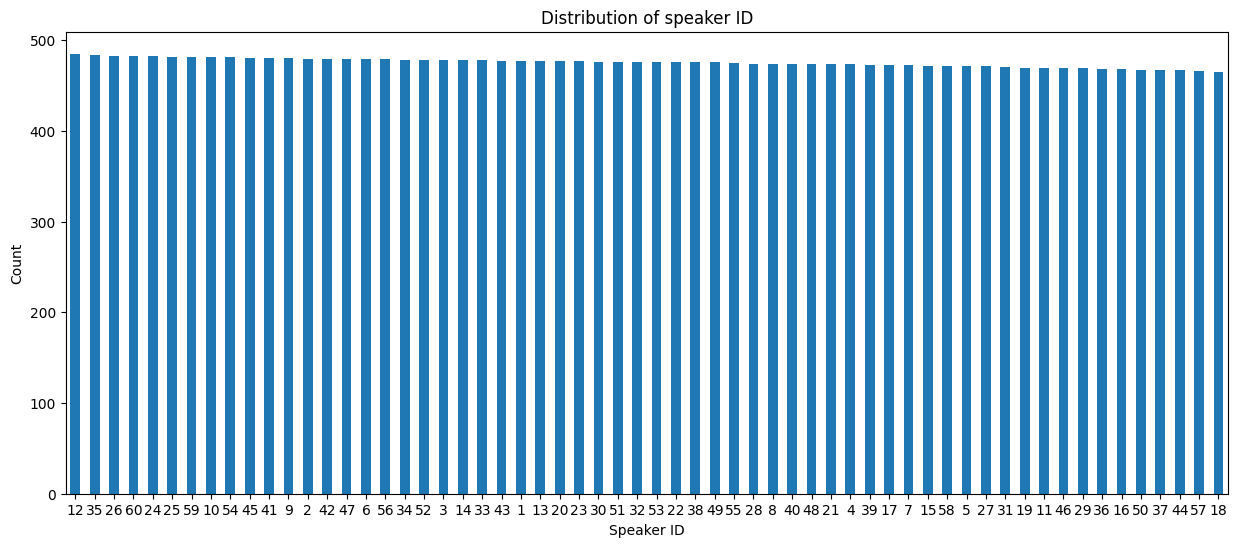

In [12]:
# visualize_data(y_train['label_1'])

series_data = pd.Series(y_train['label_1'])
class_counts = series_data.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts.plot(kind='bar', rot=0)
plt.xlabel('Speaker ID')
plt.ylabel('Count')
plt.title('Distribution of speaker ID')

# Display the bar graph
plt.show()

In [10]:
# Get the correlation matrix for speakerID labels
corr_1 = X_train.corr()

In [11]:
X_train_filtered_1_1 = reduce_correlations(corr_1, X_train, 0.6)
print(X_train_filtered_1_1.shape)

(28520, 750)


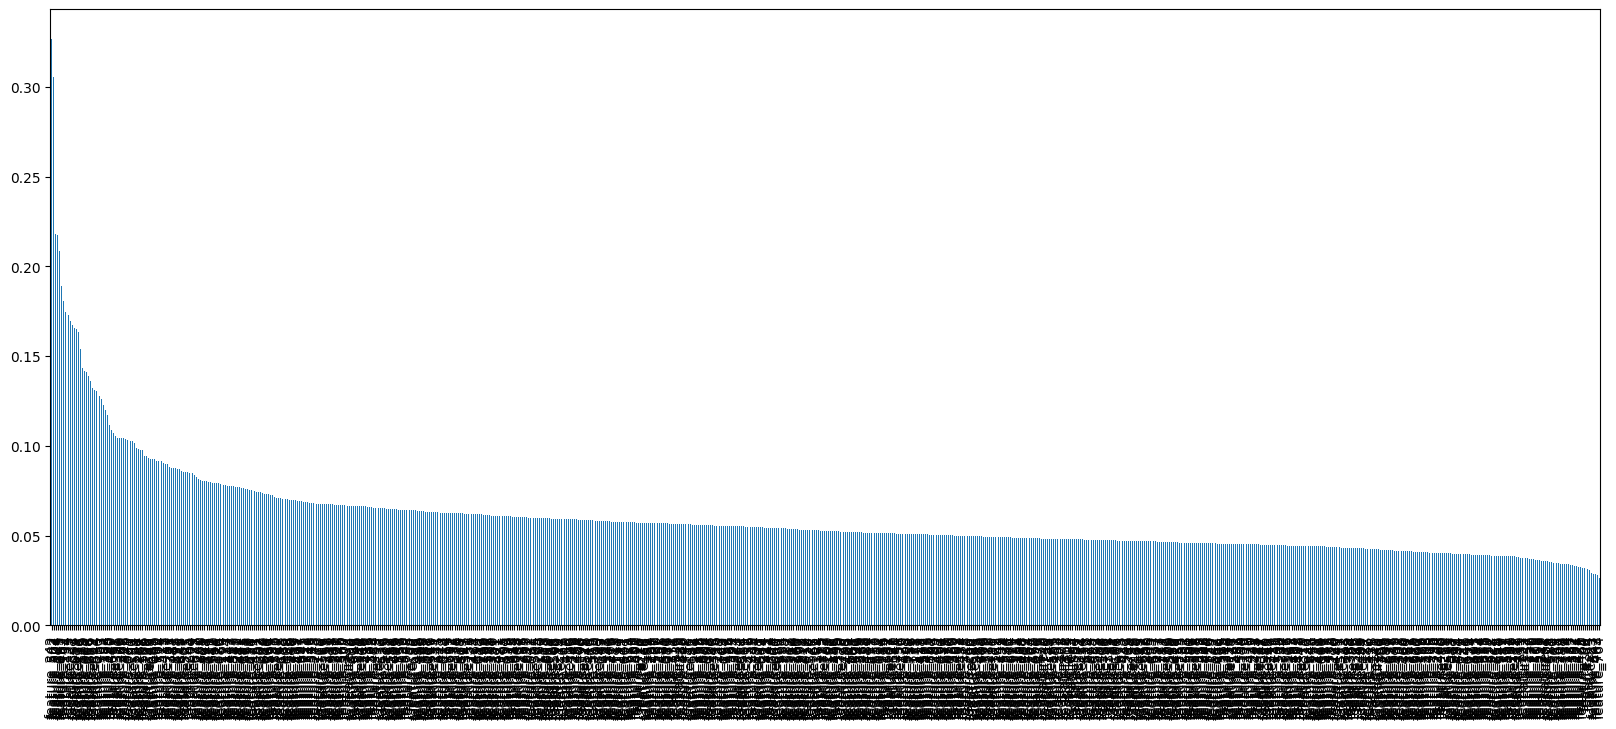

In [12]:
# Visualize mutual information

mutual_info_1 = mutual_info_classif(X_train_filtered_1_1, y_train['label_1'])
mutual_info_1 = pd.Series(mutual_info_1)
mutual_info_1.index = X_train_filtered_1_1.columns
mutual_info_1.sort_values(ascending=False).plot.bar(figsize=(20, 8))

mi_count_1 = mutual_info_1[mutual_info_1 > 0.065].count()

In [13]:
mi_count_1

163

In [26]:
selector1 = SelectKBest(score_func=mutual_info_classif, k=mi_count_1)
X_train_filtered_1_2 = selector1.fit_transform(X_train_filtered_1_1, y_train['label_1'])
X_train_filtered_1_2.shape

(28520, 163)

In [27]:
# Perform PCA on filtered dataset
print(X_train_filtered_1_2.shape)
pca_selector_1, X_train_filtered_1_3 = PCA_selection(X_train_filtered_1_2)
print(X_train_filtered_1_3.shape)

(28520, 163)
(28520, 73)


### Cross validation

Find the best fitting model with cross validation. The considered models are KNeighborsClassifier, Random Forest Classifier and the Support Vector Machine. 

In [31]:
model_1_cv = cross_validate(X_train_filtered_1_3, y_train['label_1'])

Cross validation for KNN done. F-Score :  [0.92040673 0.92654278 0.92110799 0.92075736 0.92619215]
Cross validation for RF done. F-Score :  [0.90532959 0.90129734 0.90252454 0.90042076 0.90269986]
Cross validation for SVM done. F-Score :  [0.96002805 0.96020337 0.95687237 0.95687237 0.95880084]
Max mean f-score :  0.958555399719495
SVM returned


In [37]:
rs = svm_tuner(model_1_cv, X_train_filtered_1_3, y_train['label_1'], X_valid_filtered_1_3, y_valid['label_1'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  12.6s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  12.4s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  12.7s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  12.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  12.3s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  10.7s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  10.7s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  10.4s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  10.3s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  10.4s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  19.6s
[CV] END ...................C=0.1, gamma=0.01, k

In [38]:
rs.best_params_

{'kernel': 'linear', 'gamma': 0.01, 'C': 1}

In [40]:
# Train the model accordingly and evaluate
model_1 = SVC(kernel="linear", C=1, gamma=0.01)
model_1.fit(X_train_filtered_1_3, y_train['label_1'])

SVC(C=1, gamma=0.01, kernel='linear')

In [41]:
evaluate_model(model_1, X_valid_filtered_1_3, y_valid['label_1'])

0.9293333333333333

Through manual hyperparameter tuning the following model was found to perform better than the above selected one.

In [42]:
# Train a KNN model on the filtered dataset
model_1 = KNeighborsClassifier(n_neighbors = 4)
model_1.fit(X_train_filtered_1_3, y_train['label_1'])

KNeighborsClassifier(n_neighbors=4)

In [43]:
# Evaluate the model's performance
X_valid_filtered_1_1 = X_valid[X_train_filtered_1_1.columns]
X_valid_filtered_1_2 = selector1.transform(X_valid_filtered_1_1)
X_valid_filtered_1_3 = pca_selector_1.transform(X_valid_filtered_1_2)
print(evaluate_model(model_1, X_valid_filtered_1_3, y_valid['label_1']))

0.9373333333333334


In [45]:
# hyperparameter tuning

# from sklearn.model_selection import GridSearchCV

# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train_filtered_2, y_train['label_1'])

# param_grid = {'n_neighbors': list(range(1,15)),'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }
# gs = GridSearchCV(knn_clf, param_grid, cv=10)
# gs.fit(X_train_filtered_2, y_train['label_1'])

# print(gs.cv_results_['params'])
# print(gs.best_params_)
# print(gs.cv_results_['mean_test_score'])

### Modelling label_2 : Speaker Age

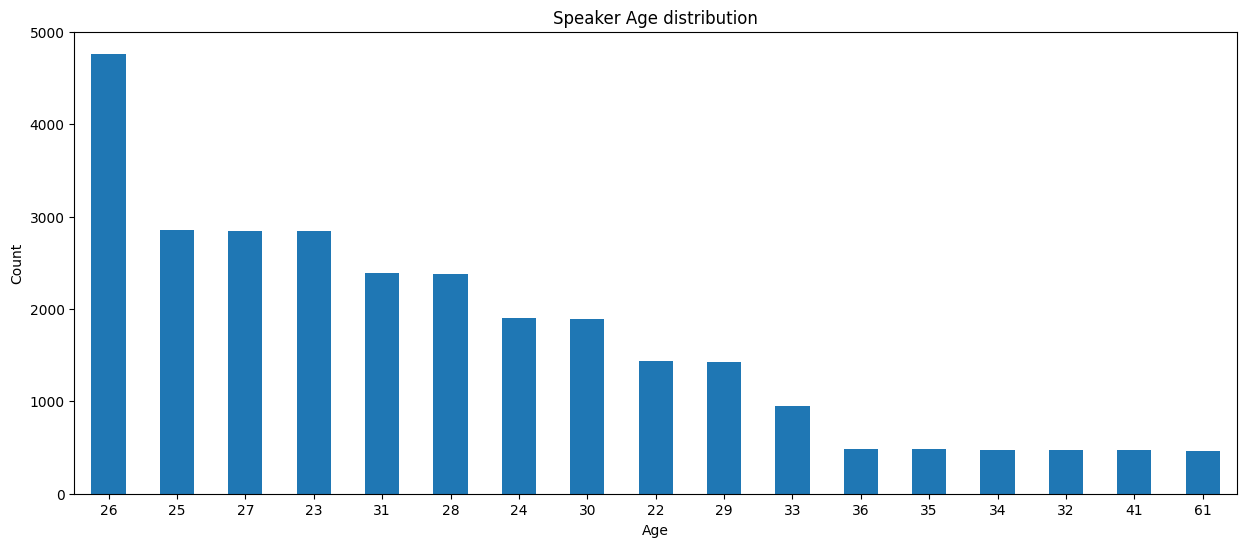

In [46]:
series_data_2 = pd.Series(y_train['label_2'])
class_counts_2 = series_data_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_2.plot(kind='bar', rot=0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Speaker Age distribution')

# Display the bar graph
plt.show()

In [47]:
# Sampling rates calculation

max_count = max(class_counts_2)
print(max_count)
sampling_rates = {}
for c in class_counts_2.keys():
    if class_counts_2[c] > 2000 and class_counts_2[c] < max_count:
        sampling_rates[c] = int(0.95 * max_count)
    elif class_counts_2[c] > 1000 and class_counts_2[c] < max_count:
        sampling_rates[c] = int(0.9 * max_count)
    elif class_counts_2[c] < 1000:
        sampling_rates[c] = int(0.85 * max_count)

print(sampling_rates)

smote_2 = SMOTE(sampling_strategy=sampling_rates, random_state=42)
Xr_train, yr_train= smote_2.fit_resample(X_train, y_train['label_2'])


4762
{25: 4523, 27: 4523, 23: 4523, 31: 4523, 28: 4523, 24: 4285, 30: 4285, 22: 4285, 29: 4285, 33: 4047, 36: 4047, 35: 4047, 34: 4047, 32: 4047, 41: 4047, 61: 4047}


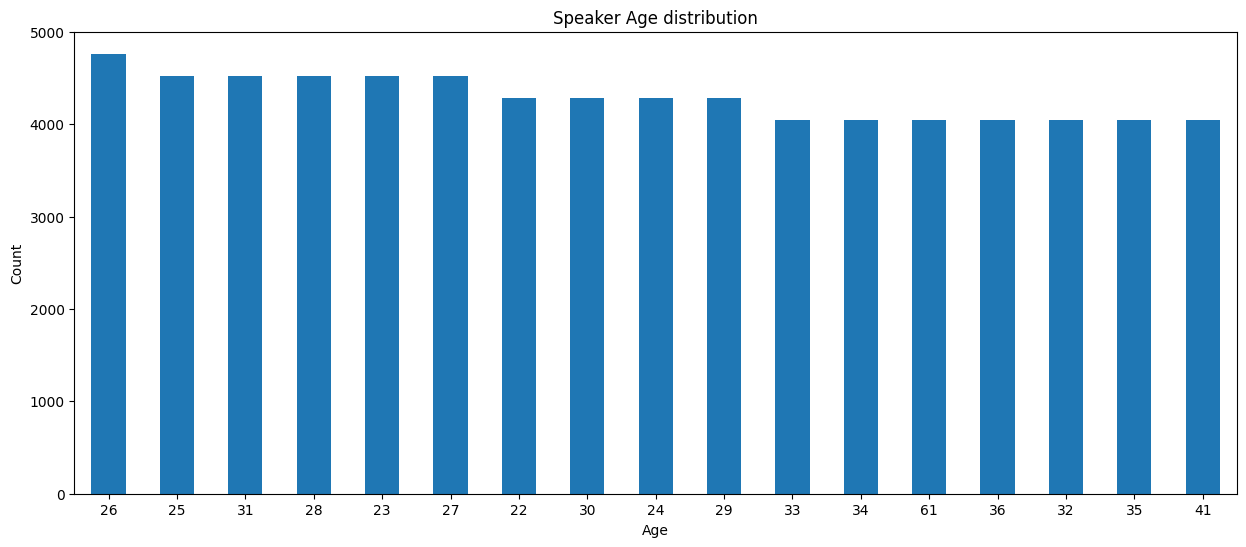

In [48]:
series_data_2_2 = pd.Series(yr_train)
class_counts_2_2 = series_data_2_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_2_2.plot(kind='bar', rot=0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Speaker Age distribution')

# Display the bar graph
plt.show()

Now that the classes are balanced, let's start with removing features. We have to first find the correlation matrix of X_train_resampled and remove highly correlated featues. Then we have to remove mutual info. Then PCA

In [49]:
corr_2 = Xr_train.corr()

In [50]:
X_train_filtered_2_1 = reduce_correlations(corr_2, Xr_train, 0.6)
print(X_train_filtered_2_1.shape)

(72846, 743)


<Axes: >

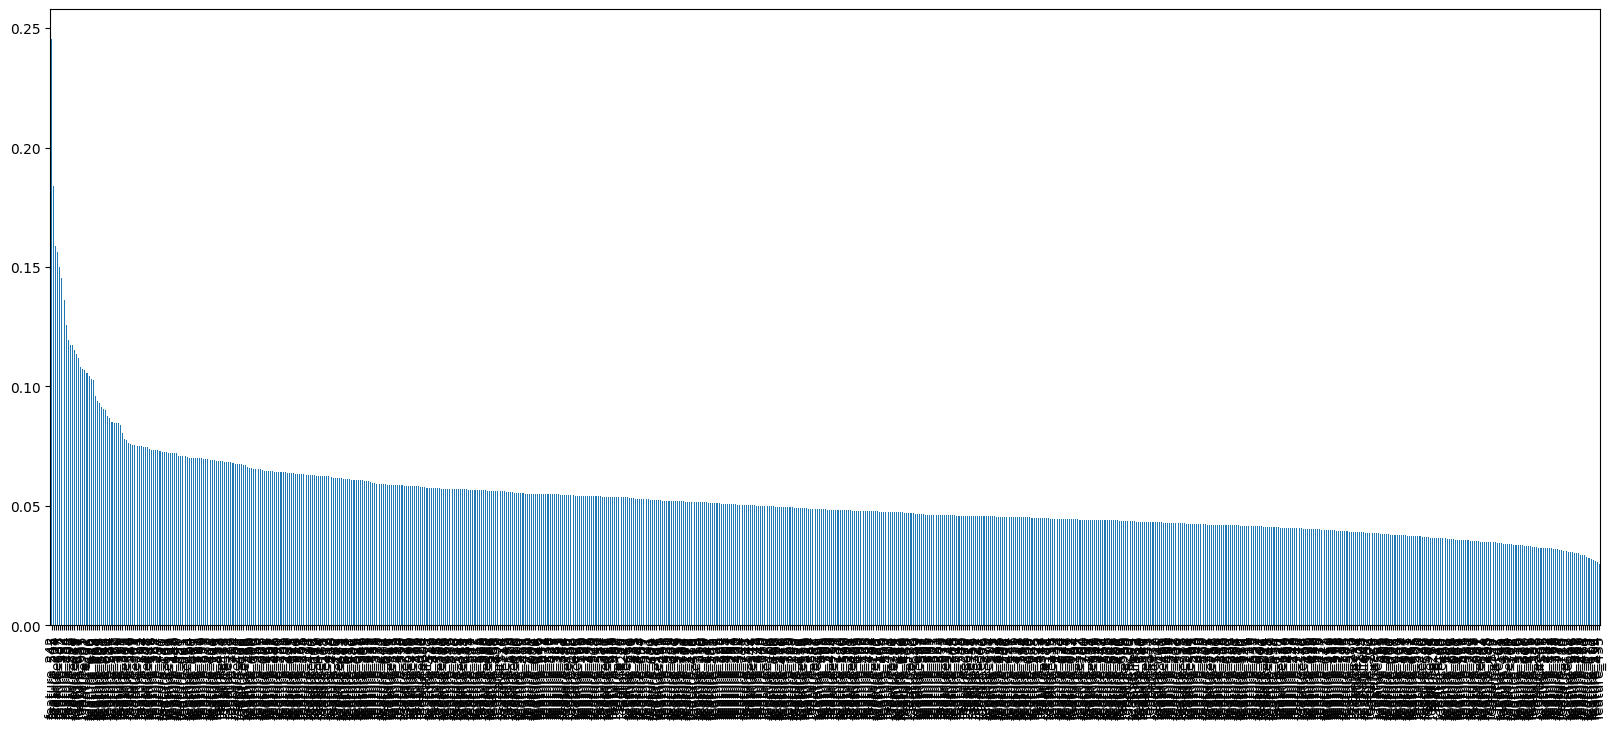

In [32]:
# Visualize mutual information

mutual_info_2 = mutual_info_classif(X_train_filtered_2_1, yr_train)
mutual_info_2 = pd.Series(mutual_info_2)
mutual_info_2.index = X_train_filtered_2_1.columns
mutual_info_2.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [33]:
mi_count_2 = mutual_info_2[mutual_info_2 > 0.06].count()
mi_count_2

154

In [34]:
selector2 = SelectKBest(score_func=mutual_info_classif, k=mi_count_2)

X_train_filtered_2_2 = selector2.fit_transform(X_train_filtered_2_1, yr_train)
X_train_filtered_2_2.shape

(72846, 154)

In [51]:
# Perform PCA on filtered dataset
pca_selector_2, X_train_filtered_2_3 = PCA_selection(X_train_filtered_2_1)
print(X_train_filtered_2_3.shape)

(72846, 216)


### Cross Validation

In [54]:
model_2_cv = cross_validate(X_train_filtered_2_3, yr_train)

Cross validation for KNN done. F-Score :  [0.9026081  0.91111264 0.91674103 0.92991969 0.93657766]
Cross validation for RF done. F-Score :  [0.88119423 0.89759077 0.90740614 0.93904866 0.95202142]
Cross validation for SVM done. F-Score :  [0.90150995 0.91433866 0.92518361 0.93142975 0.93657766]
Max mean f-score :  0.9218079276552686
SVM returned


In [57]:
X_valid_filtered_2_1 = X_valid[X_train_filtered_2_1.columns]
X_valid_filtered_2_3 = pca_selector_2.transform(X_valid_filtered_2_1)
print(X_valid_filtered_2_3.shape)
print(y_valid['label_2'].shape)

(750, 216)
(750,)


In [60]:
rs2 = svm_tuner(model_2_cv, X_train_filtered_2_3, yr_train, X_valid_filtered_2_3, y_valid['label_2'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.6min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.5min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.5min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.7min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.7min
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time= 1.4min
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time= 1.5min
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=17.4min
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time= 1.9min
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time= 1.8min
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time= 2.7min
[CV] END ...................C=0.1, gamma=0.01, k

KeyboardInterrupt: 

In [61]:
model_2_cv.fit(X_train_filtered_2_3, yr_train)

SVC(random_state=42)

In [64]:
evaluate_model(model_2_cv, X_valid_filtered_2_3, y_valid['label_2'])

0.9533333333333334

## Modeling label_3 : Speaker Gender

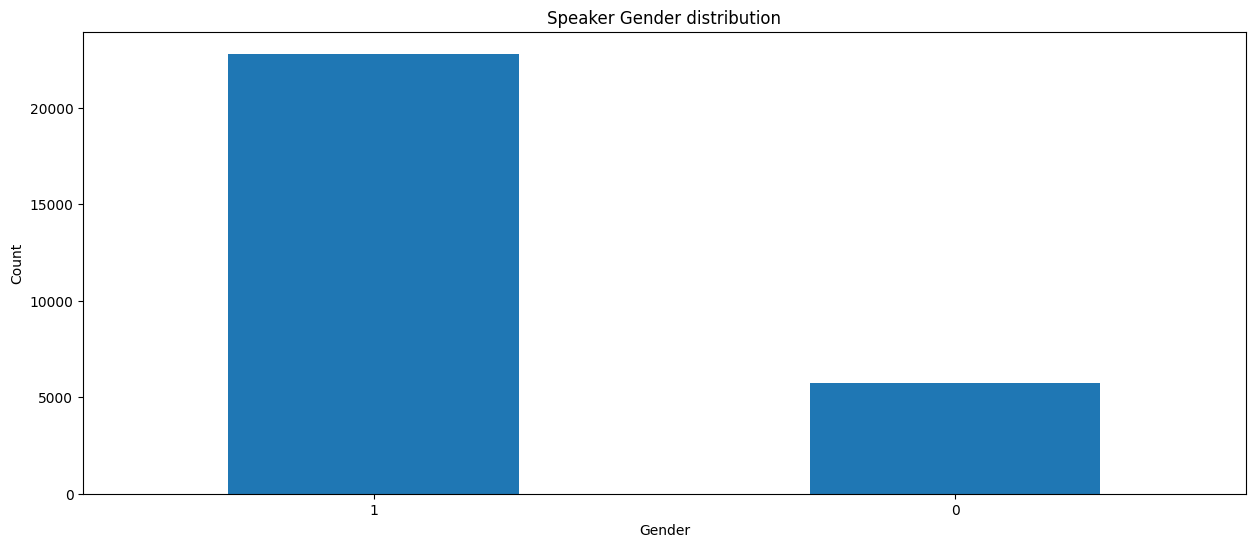

In [48]:
series_data_3 = pd.Series(y_train['label_3'])
class_counts_3 = series_data_3.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_3.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Speaker Gender distribution')

# Display the bar graph
plt.show()

There is class imbalance. Let's oversample.

In [49]:
oversampler3 = RandomOverSampler(sampling_strategy= 0.85, random_state=42)
Xr_train, yr_train = oversampler3.fit_resample(X_train, y_train['label_3'])

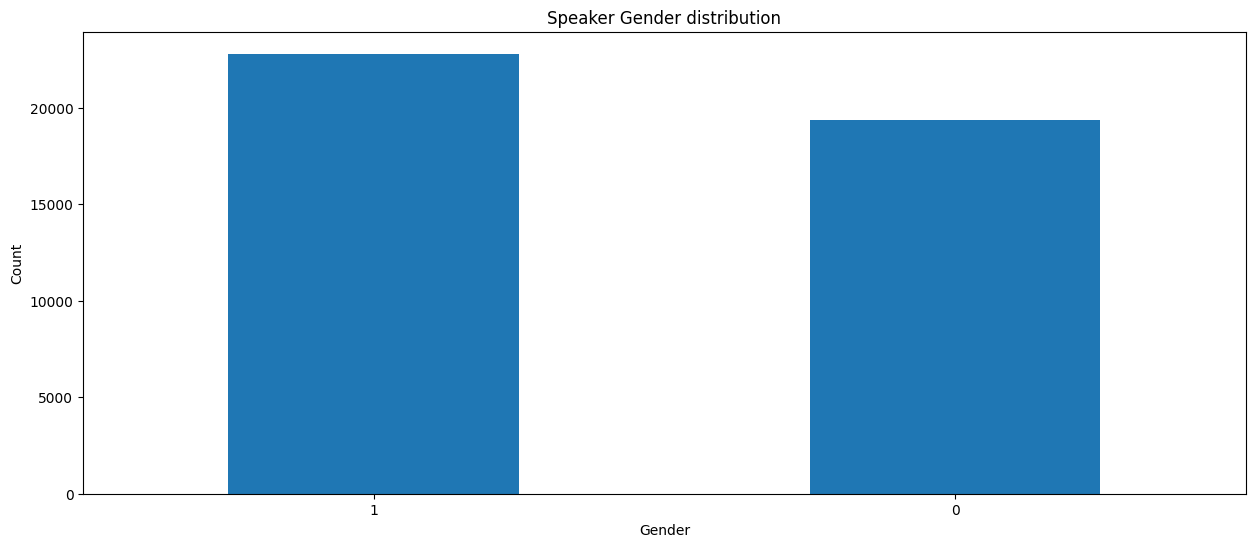

In [50]:
series_data_3_2 = pd.Series(yr_train)
class_counts_3_2 = series_data_3_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_3_2.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Speaker Gender distribution')

# Display the bar graph
plt.show()

In [51]:
corr_3 = Xr_train.corr()

In [52]:
X_train_filtered_3_1 = reduce_correlations(corr_3, Xr_train, 0.6)
print(X_train_filtered_3_1.shape)

(42172, 749)


In [53]:
selector3 = SelectKBest(score_func=f_classif, k=150)
X_train_filtered_3_2 = selector3.fit_transform(X_train_filtered_3_1, yr_train)
X_train_filtered_3_2.shape

(42172, 150)

In [54]:
# Perform PCA on filtered dataset
scaler_3, pca_selector_3, X_train_filtered_3_3 = PCA_selection(X_train_filtered_3_2)
print(X_train_filtered_3_3.shape)

(42172, 101)


In [70]:
# Hyperparameter tuning and cross validation
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train_filtered_3_3, yr_train)

param_grid = {'n_neighbors': list(range(1,15))}
gs = GridSearchCV(knn_clf, param_grid, cv=10)
gs.fit(X_train_filtered_3_3, yr_train)

print(gs.best_params_)

{'n_neighbors': 1}


In [69]:
gs.cv_results_['params']

[{'n_neighbors': 1},
 {'n_neighbors': 2},
 {'n_neighbors': 3},
 {'n_neighbors': 4},
 {'n_neighbors': 5},
 {'n_neighbors': 6},
 {'n_neighbors': 7},
 {'n_neighbors': 8},
 {'n_neighbors': 9},
 {'n_neighbors': 10},
 {'n_neighbors': 11},
 {'n_neighbors': 12},
 {'n_neighbors': 13},
 {'n_neighbors': 14}]

In [55]:
# Train a KNN model on the filtered dataset
model_3 = KNeighborsClassifier(n_neighbors = 3)
model_3.fit(X_train_filtered_3_3, yr_train)

KNeighborsClassifier(n_neighbors=3)

In [56]:
# Oversample the valid dataset
Xr_valid_3, yr_valid_3 = oversampler3.fit_resample(X_valid, y_valid['label_3']) 
X_valid_filtered_3_1 = Xr_valid_3[X_train_filtered_3_1.columns]
X_valid_filtered_3_2 = selector3.transform(X_valid_filtered_3_1)
X_valid_filtered_3_3 = pca_selector_3.transform(scaler_3.transform(X_valid_filtered_3_2))
print(evaluate_model(model_3, X_valid_filtered_3_3, yr_valid_3))

0.9911032028469751


## Modeling label_4 : Speaker Accent

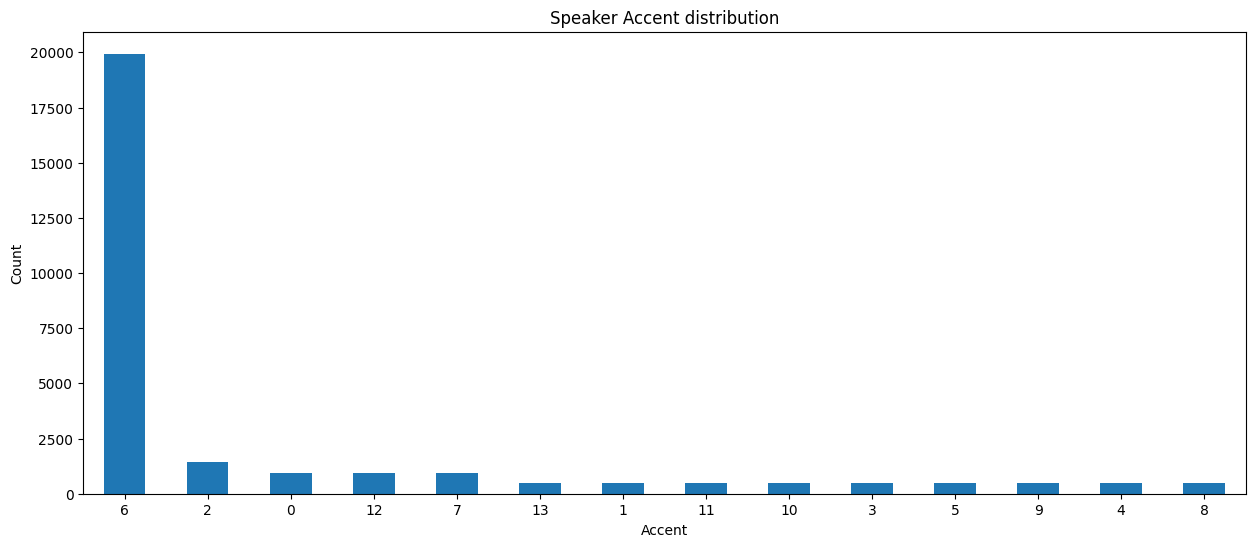

In [65]:
series_data_4 = pd.Series(y_train['label_4'])
class_counts_4 = series_data_4.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_4.plot(kind='bar', rot=0)
plt.xlabel('Accent')
plt.ylabel('Count')
plt.title('Speaker Accent distribution')

# Display the bar graph
plt.show()

In [66]:
from imblearn.over_sampling import SMOTE

# Define the desired number of samples per class (e.g., equal to the count of the majority class)
# desired_count = class_counts.mean()

# Instantiate the SMOTE sampler
smote_4 = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the data
Xr_train_4, yr_train_4 = smote_4.fit_resample(X_train, y_train['label_4'])

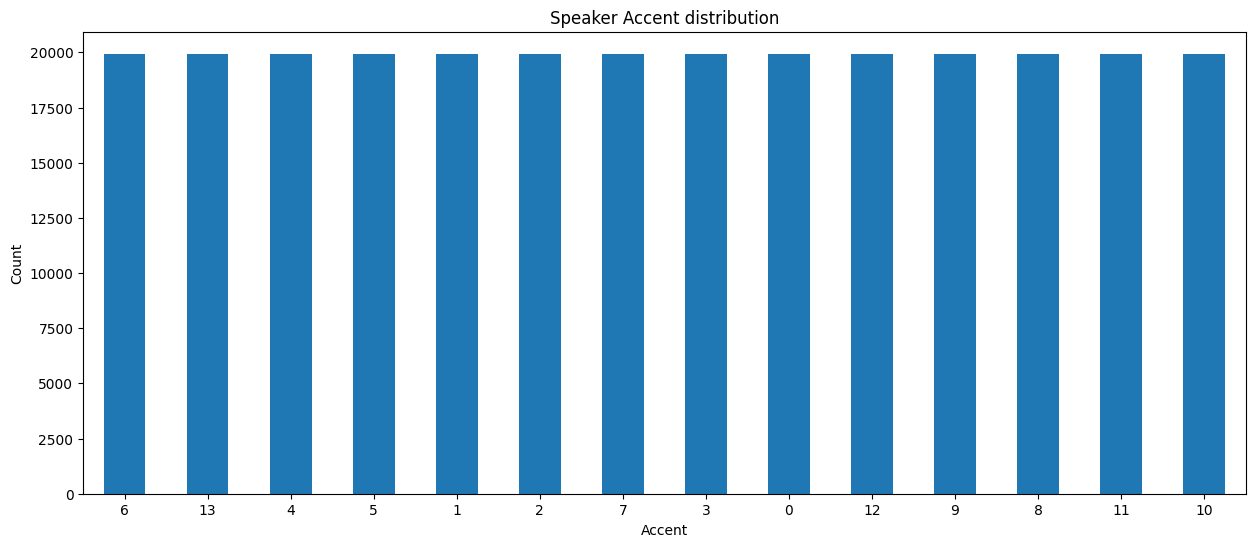

In [67]:
series_data_4_2 = pd.Series(yr_train_4)
class_counts_4_2 = series_data_4_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_4_2.plot(kind='bar', rot=0)
plt.xlabel('Accent')
plt.ylabel('Count')
plt.title('Speaker Accent distribution')

# Display the bar graph
plt.show()

In [68]:
corr_4 = Xr_train_4.corr()

In [69]:
X_train_filtered_4_1 = reduce_correlations(corr_4, Xr_train_4, 0.6)
print(X_train_filtered_4_1.shape)

(279132, 732)


In [70]:
selector4 = SelectKBest(score_func=mutual_info_classif, k=300)
X_train_filtered_4_2 = selector4.fit_transform(X_train_filtered_4_1, yr_train_4)
X_train_filtered_4_2.shape

MemoryError: Unable to allocate 1.52 GiB for an array with shape (279132, 732) and data type float64

In [65]:
# Perform PCA on filtered dataset
scaler_4, pca_selector_4, X_train_filtered_4_3 = PCA_selection(X_train_filtered_4_2)
print(X_train_filtered_4_3.shape)

(279132, 94)


In [ ]:
model_4_cv = cross_validate(X_train_filtered_4_3, yr_train_4)

In [66]:
# Train a KNN model on the filtered dataset
model_4 = KNeighborsClassifier(n_neighbors = 4)
model_4.fit(X_train_filtered_4_3, yr_train_4)

KNeighborsClassifier(n_neighbors=4)

In [68]:
# Oversample the valid dataset
Xr_valid_4, yr_valid_4 = smote_4.fit_resample(X_valid, y_valid['label_4']) 
X_valid_filtered_4_1 = Xr_valid_4[X_train_filtered_4_1.columns]
X_valid_filtered_4_2 = selector4.transform(X_valid_filtered_4_1)
X_valid_filtered_4_3 = pca_selector_4.transform(scaler_4.transform(X_valid_filtered_4_2))
print(evaluate_model(model_4, X_valid_filtered_4_3, yr_valid_4))

0.9485767991407089


In [116]:
from sklearn.model_selection import GridSearchCV
knn_clf_2 = KNeighborsClassifier()
# knn_clf_2.fit(X_train_filtered_7, y_resampled_4)

param_grid = {'n_neighbors': list(range(1,15))}
gs = GridSearchCV(knn_clf_2,param_grid,cv=10)
gs.fit(X_valid_filtered_4_3, yr_valid_4)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]})

In [117]:
gs.best_params_

{'n_neighbors': 1}

# Testing the models

In [69]:
# Read test data
test = pd.read_csv('dataset_layer7/test.csv')
test.shape

(744, 769)

In [83]:
# Predict the results for all 4 labels
# Preprocess the data according to the 4 models

## LABEL 1
test_filtered_1_1 = test[X_train_filtered_1_1.columns]
test_filtered_1_2 = selector1.transform(test_filtered_1_1)
test_filtered_1_3 = pca_selector_1.transform(scaler_1.transform(test_filtered_1_2))

## LABEL 2 
test_filtered_2_1 = test[X_train_filtered_2_1.columns]
test_filtered_2_2 = selector2.transform(test_filtered_2_1)
test_filtered_2_3 = pca_selector_2.transform(scaler_2.transform(test_filtered_2_2))

## LABEL 3
test_filtered_3_1 = test[X_train_filtered_3_1.columns]
test_filtered_3_2 = selector3.transform(test_filtered_3_1)
test_filtered_3_3 = pca_selector_3.transform(scaler_3.transform(test_filtered_3_2))

## LABEL 4
test_filtered_4_1 = test[X_train_filtered_4_1.columns]
test_filtered_4_2 = selector4.transform(test_filtered_4_1)
test_filtered_4_3 = pca_selector_4.transform(scaler_4.transform(test_filtered_4_2))

In [84]:
test_1_pred = model_1.predict(test_filtered_1_3)
test_1_pred

array([26, 18, 16,  7, 58, 46,  7, 22, 21, 26, 33,  6, 54, 51, 29, 48, 23,
        2, 52, 42, 11, 35, 39, 36, 44, 48, 28, 55,  2, 51, 55, 46,  1, 56,
       30, 53, 50,  6, 34, 18, 19, 47,  6, 46, 59, 25, 31, 35,  5, 32, 25,
       56, 39, 37, 32, 29, 46, 52, 28, 34, 16, 47, 55, 24, 23,  1, 20,  6,
       36, 38, 22, 28, 44, 46, 55, 59, 49, 40, 57, 12, 52, 38, 29,  4, 31,
       49, 14, 19, 12, 39, 36, 43, 34, 32, 54, 46, 27,  5,  7, 42, 19, 26,
       31, 36, 53, 10, 12, 33, 38,  2, 57, 37, 17, 50, 46, 46, 17, 34,  2,
       40, 19, 40,  8, 22, 38, 15, 39,  9, 52,  5, 28, 13, 10, 55, 28, 25,
       42, 57, 16, 27, 22,  2, 51, 27, 32, 46, 16,  3, 11, 46, 42, 37, 47,
       50,  3, 41, 19, 20, 15,  8,  3, 18,  5, 28, 46,  4, 16, 40, 17, 20,
       11, 57, 27, 16, 11, 35, 34, 52, 15, 55,  7, 18, 21, 19, 37, 55, 15,
       28, 23, 35, 46, 52, 30, 27, 13,  7, 28, 14,  3, 58, 17, 60, 18,  3,
       22,  9,  5, 25, 17, 26, 19, 36, 25, 21,  1, 44, 39, 47, 38,  6, 50,
       39, 23, 37, 48, 22

In [85]:
test_2_pred = model_2.predict(test_filtered_2_3)
test_2_pred

array([22, 25, 30, 27, 29, 30, 27, 33, 22, 22, 26, 25, 27, 26, 23, 26, 28,
       25, 34, 29, 33, 24, 29, 22, 61, 22, 28, 23, 25, 26, 23, 30, 30, 24,
       28, 24, 24, 25, 27, 25, 23, 23, 25, 30, 31, 29, 26, 32, 25, 23, 22,
       24, 29, 27, 23, 23, 24, 34, 28, 25, 30, 23, 23, 26, 28, 25, 25, 25,
       22, 32, 33, 28, 61, 30, 23, 23, 26, 31, 27, 26, 34, 32, 24, 23, 26,
       26, 31, 23, 26, 29, 29, 31, 25, 23, 27, 30, 31, 25, 27, 29, 23, 22,
       26, 22, 24, 36, 26, 32, 32, 25, 27, 27, 26, 24, 30, 30, 26, 25, 23,
       26, 23, 26, 41, 33, 32, 28, 29, 35, 34, 25, 28, 27, 36, 23, 28, 22,
       29, 27, 30, 31, 23, 25, 26, 31, 23, 30, 30, 31, 33, 30, 29, 27, 23,
       24, 31, 30, 23, 25, 28, 41, 31, 25, 25, 28, 30, 25, 30, 26, 26, 25,
       23, 27, 31, 30, 33, 31, 25, 34, 30, 23, 27, 25, 27, 23, 27, 23, 26,
       28, 28, 24, 30, 34, 28, 31, 27, 30, 28, 31, 31, 22, 26, 27, 25, 31,
       33, 35, 30, 22, 26, 22, 25, 22, 22, 26, 30, 61, 29, 23, 32, 25, 24,
       29, 28, 27, 26, 33

In [86]:
test_3_pred = model_3.predict(test_filtered_3_3)
test_3_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [87]:
test_4_pred = model_4.predict(test_filtered_4_3)
test_4_pred

array([ 2,  8,  6,  8,  6,  6,  6,  6,  2,  2,  6,  6,  6,  6,  6,  6,  8,
        6,  5,  0,  6,  2, 10,  6,  6,  6,  6,  6,  6,  6,  6, 10,  6,  6,
        6,  2,  6,  6,  6,  8,  4,  3,  6,  6,  6,  1,  0, 12,  6,  0,  1,
        6,  6,  7,  0,  6,  6,  5,  6,  6,  6,  3,  6,  2,  6,  8,  6,  6,
        6, 12,  6,  6,  6,  6,  6,  3,  0,  7,  6,  6,  5, 12,  1, 10,  4,
        6, 12,  4,  6,  6,  6,  6,  6,  0,  6,  6,  7,  6,  6,  0,  4,  2,
        6,  6,  6,  6,  6, 12, 12,  6,  6,  7,  6,  6,  6,  6,  1,  6,  0,
        6,  4,  6, 10,  6, 12,  9,  2, 11,  5,  7,  6,  6,  6,  6,  5,  1,
        0,  5,  6,  7,  6,  6,  6,  7,  0,  6,  6,  7,  6,  6,  0,  7,  3,
        6,  6, 10,  4,  6,  9, 10,  6,  8,  6,  6,  6,  6,  8,  6,  6,  0,
        0,  6,  7,  6,  6,  2,  6,  5, 10,  0,  6,  8,  6,  4,  7,  6,  6,
        6,  3,  2,  6,  5,  6,  7,  6,  6,  6, 12,  6,  6,  6, 13,  8,  6,
        6, 11,  2,  1,  6,  2,  2,  6,  2,  6,  6,  6,  6,  3, 12,  6,  6,
        6,  8,  7,  6,  6

In [91]:
# Write into csv file
import csv

header = ["ID", "label_1", "label_2", "label_3", "label_4"]

with open('190547P_layer7_out.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(744):
        row = [i+1, test_1_pred[i], test_2_pred[i], test_3_pred[i], test_4_pred[i]]
        writer.writerow(row)
        

## Cross validation function

In [ ]:
# cross validation function
# Here, the cross validation will be done across these models -> KNN, RandomForest and SVM
# 
from sklearn.model_selection import KFold, cross_val_score

def cross_validate(x_train, y_train, knn_neighbors):
    knn = KNeighborsClassifier(n_neighbors=knn_neighbors)
    rf = RandomForestClassifier()
    svm_lin = SVC(kernel = 'linear', C=1.0, random_state=42)
    svm_rbf = SVC(kernel = 'rbf', C=1.0, random_state=42)
    svm_pol = SVC(kernel = 'poly', C=1.0, random_state=42)
    
    all_models = [knn, rf, svm_lin, svm_rbf, svm_pol]
    
    f_score_knn = cross_val_score(knn, x_train, y_train, cv = 5, scoring=scorer)
    print("Cross validation for KNN done.\n F-Score : ", f_score_knn)
    f_score_rf = cross_val_score(rf, x_train, y_train, cv = 5, scoring=scorer)
    print("Cross validation for RF done. \n F-Score : ", f_score_rf)
    f_score_svm_lin = cross_val_score(svm, x_train, y_train, cv = 5, scoring=scorer)
    print("Cross validation for SVM(linear) done. \n F-Score : ", f_score_svm_lin)
    f_score_svm_rbf = cross_val_score(svm, x_train, y_train, cv = 5, scoring=scorer)
    print("Cross validation for SVM(rbf) done. \n F-Score : ", f_score_svm_rbf)
    f_score_svm_pol = cross_val_score(svm, x_train, y_train, cv = 5, scoring=scorer)
    print("Cross validation for SVM(poly) done. \n F-Score : ", f_score_svm_pol)
    
    mean_scores = [f_score_knn.mean(), f_score_rf.mean(), f_score_svm_lin.mean(), f_score_svm_rbf.mean(), f_score_svm_pol.mean()]
    max_f = max(mean_scores)
    best_model = all_models[mean_scores.index(max_f)]
    
    return best_model